In [1]:
import import_ipynb
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## For data
import pandas as pd
import numpy as np
import random

## For plotting
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

## For statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## For machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


%matplotlib inline

## Chinese display
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## No warnings
import warnings
warnings.filterwarnings('ignore') 

## Data preprocessing

In [2]:
df = pd.read_excel('raw_data/腹泻病个案信息一览2017-2018.xlsx',
                   sheet_name=0,
                   engine='openpyxl')
print(df.shape)

df["性别"] = df["性别"].map(lambda x: x.strip())
df["性别"] = df["性别"].map(lambda x: "Male" if x ==
                        "男" or x == "男性" else "Female")


(38168, 107)


In [ ]:
columns = []
# Percentage of missing data
print("\npercentage of missing data")
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")
    if ratio >= 98:
        pass
    else:
        columns.append(col)

df = df[columns]
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")

In [6]:
# Extract the required columns
X = ["区县", "性别", "age", "户籍", "职业", "首发症状", "发热", "体温", "脱水",
     "腹胀", "恶心", "里急后重", "肠鸣音亢进", "腹痛", "腹痛性质", "腹痛部位", "呕吐", "呕吐频次", "呕吐在腹泻___发生", "持续天数",
     "腹泻", "腹泻量", "腹泻频次", "腹泻天数", "腹泻性质", "神经症状", "中毒症状", "其他症状", "近6个月有无肠道疾病既往史",
     "发病前五天内是否有不洁饮食史", "进餐地点", "发病前5天内是否有不洁饮水史", "发病前5天内周边有无类似腹泻病例", "疑似病例人数",
     "发病前5天内是否有聚餐史", "发病前一周是否外出", "是否家中饲养或接触过宠物", "就诊前是否服用过抗生素",
     "诊断", "诊断类型", "临床处理", "本次就诊是否给予抗生素", "抗生素名称.1", "是否采集", "采样类型"]
y = ["细菌结果"]
data = df[X + y]

data_file = "data\Diarrhea_new.tsv"
data.to_csv(data_file, sep="\t", encoding="utf-8")

In [7]:
data_file = "data\Diarrhea_new.tsv"
df = pd.read_csv(data_file, sep="\t", index_col=0, encoding="utf-8")

## Age and gender distribution

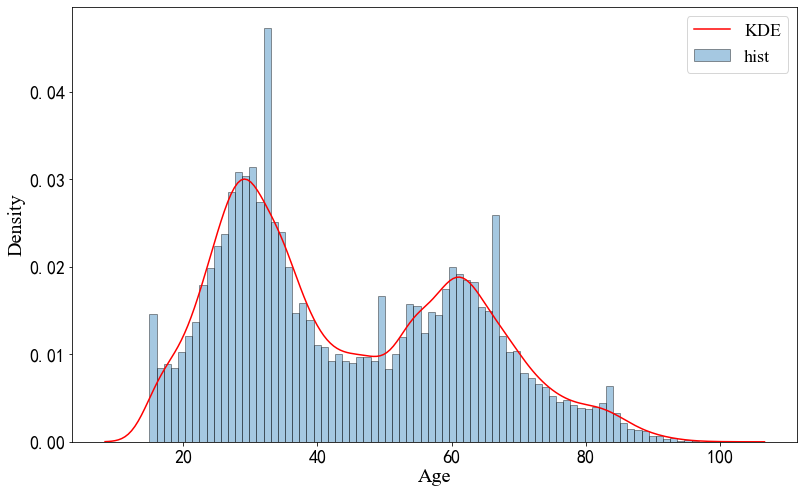

In [10]:
plt.figure(figsize=(13, 8))
x = "age"

age = sns.distplot(df[x], bins=80, hist_kws={'label': 'hist', 'edgecolor': 'black'},
                 kde_kws={'color': 'red', 'label': 'KDE'},
                 )

# Settings for legend
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 18,
         }
age.legend(prop=font1, loc='best')

# Settings for scale
age.tick_params(labelsize=18)
labels = age.get_xticklabels() + age.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

# Setting for coordinate axis
font2 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,
         }
age.set_xlabel('Age', font2)
age.set_ylabel('Density', font2);

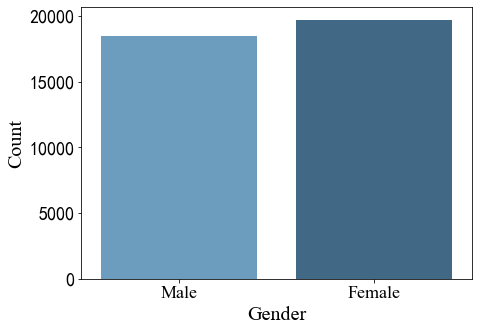

In [11]:
plt.figure(figsize=(7, 5))
gender = sns.countplot(x="性别", data=df,palette="Blues_d")
gender.tick_params(labelsize=18)
labels = gender.get_xticklabels() + gender.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# p.set_xticklabels(['Male','Female'])
gender.set_xlabel('Gender',font2)
gender.set_ylabel('Count',font2);

## Missing Value Processing

In [14]:
# Delete rows with null values in the "Bacteria Results" column
df.dropna(axis=0, how='any', subset=['细菌结果'], inplace=True)
print(df.shape)

# Missing value filling
df["age"].fillna(df["age"].mean(), inplace=True)
df["体温"].fillna(df["体温"].mode()[0], inplace=True)

df.loc[df['呕吐'] == "无", '呕吐频次'] = 0
df['呕吐频次'].fillna(1, inplace=True)

df.loc[df['呕吐'] == "无", '持续天数'] = 0
df['持续天数'].fillna(1, inplace=True)

columns = ["腹泻量", "腹泻频次", "腹泻天数"]
for column in columns:
    df.loc[df['腹泻'] == "无", column] = 0
    df[column].fillna(df[column].mean(), inplace=True)

def yes_no(x):
    if x == "否" or x == "无":
        return "无"
    else:
        return "有"

df['发病前5天内周边有无类似腹泻病例'] = df['发病前5天内周边有无类似腹泻病例'].map(yes_no)
df.loc[df['发病前5天内周边有无类似腹泻病例'] == "无", '疑似病例人数'] = 0
df['疑似病例人数'].fillna(1, inplace=True)

(11600, 46)


In [15]:
x = ["职业", "首发症状", "腹痛性质", "腹痛部位", "呕吐在腹泻___发生", "神经症状", "中毒症状", "其他症状",
     "进餐地点", "发病前一周是否外出", "是否家中饲养或接触过宠物", "诊断类型", "临床处理", "抗生素名称.1"]
for column in x:
    df[column].fillna("无", inplace=True)


x = ["发病前五天内是否有不洁饮食史", "发病前5天内是否有不洁饮水史", "发病前5天内周边有无类似腹泻病例",
     "发病前5天内是否有聚餐史", "发病前一周是否外出", "是否家中饲养或接触过宠物", "就诊前是否服用过抗生素",
     "本次就诊是否给予抗生素", "是否采集"]
for column in x:
    df[column] = df[column].map(yes_no)

In [16]:
# Check if there are still empty values in each column
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)*100
    print(f"{col:25s} {ratio:3.0f} %")

区县                          0 %
性别                          0 %
age                         0 %
户籍                          0 %
职业                          0 %
首发症状                        0 %
发热                          0 %
体温                          0 %
脱水                          0 %
腹胀                          0 %
恶心                          0 %
里急后重                        0 %
肠鸣音亢进                       0 %
腹痛                          0 %
腹痛性质                        0 %
腹痛部位                        0 %
呕吐                          0 %
呕吐频次                        0 %
呕吐在腹泻___发生                  0 %
持续天数                        0 %
腹泻                          0 %
腹泻量                         0 %
腹泻频次                        0 %
腹泻天数                        0 %
腹泻性质                        0 %
神经症状                        0 %
中毒症状                        0 %
其他症状                        0 %
近6个月有无肠道疾病既往史               0 %
发病前五天内是否有不洁饮食史              0 %
进餐地点                        0 %
发病前5天内是否

In [18]:
# Remove spaces
obj = df.dtypes[df.dtypes == 'object'].index.tolist()
obj.remove("腹泻性质")
for column in obj:
    df[column] = df[column].astype('object')
    df[column] = df[column].map(lambda x: x.strip())

In [19]:
df_file = "data/Diarrhea_fillna.tsv"
df.to_csv(df_file, sep="\t", encoding="utf-8")

## Experiments

In [20]:
df_file = "data/Diarrhea_fillna.tsv"
df = pd.read_csv(df_file, sep="\t", index_col=0, encoding="utf-8")

In [22]:
y = "细菌结果"
df[y] = df[y].map(lambda x: 0 if x == "阴性" else 1)

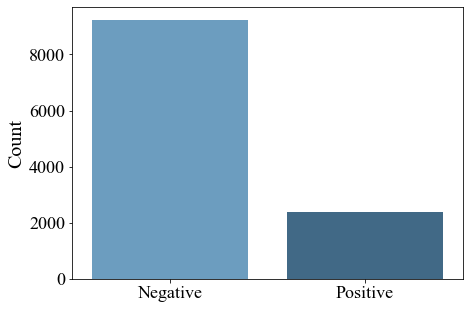

In [23]:
plt.figure(figsize=(7, 5))
result = sns.countplot(x="细菌结果", data=df, palette="Blues_d")
result.tick_params(labelsize=18)
labels = result.get_xticklabels() + result.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
result.set_xticklabels(['Negative', 'Positive'])
result.set_xlabel('', font2)
# p.set_xlabel('Bacterial infection results',font2)
result.set_ylabel('Count', font2)

### Feature selection
#### 1. Statistical-based methods 

In [48]:
## Continuous data: one-way ANOVA
def correlation_anova(x,y,df):
    """
    one-way ANOVA test
    """
    model = smf.ols(x+' ~ '+y, data=df).fit()
    table = sm.stats.anova_lm(model)
    p = table["PR(>F)"][0]
    coeff, p = None, round(p, 3)
    conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
    # print(f"Anova F: the variables {x, y} are", conclusion, "(p-value: "+str(p)+")")
    return p, conclusion

obj_columns = df.select_dtypes(include=object).columns.to_list()
cont_columns = [column for column in df.columns if column not in obj_columns]
cont_columns

['age', '体温', '呕吐频次', '持续天数', '腹泻量', '腹泻频次', '腹泻天数', '疑似病例人数', '细菌结果']

In [49]:
y = "细菌结果"
cont_p = []
cont_conclusion = []
for column in cont_columns:
    p, conclusion = correlation_anova(column,y,df)
    cont_p.append(p)
    cont_conclusion.append(conclusion)

list_of_tuple = list(zip(cont_p,cont_conclusion))
cont_result = pd.DataFrame(data=list_of_tuple,index=cont_columns,columns=["P Value", "Effective"])
cont_result.head()

,P Value,Effective
age,0.000,Correlated
体温,0.000,Correlated
呕吐频次,0.116,Non-Correlated
持续天数,0.234,Non-Correlated
腹泻量,0.000,Correlated


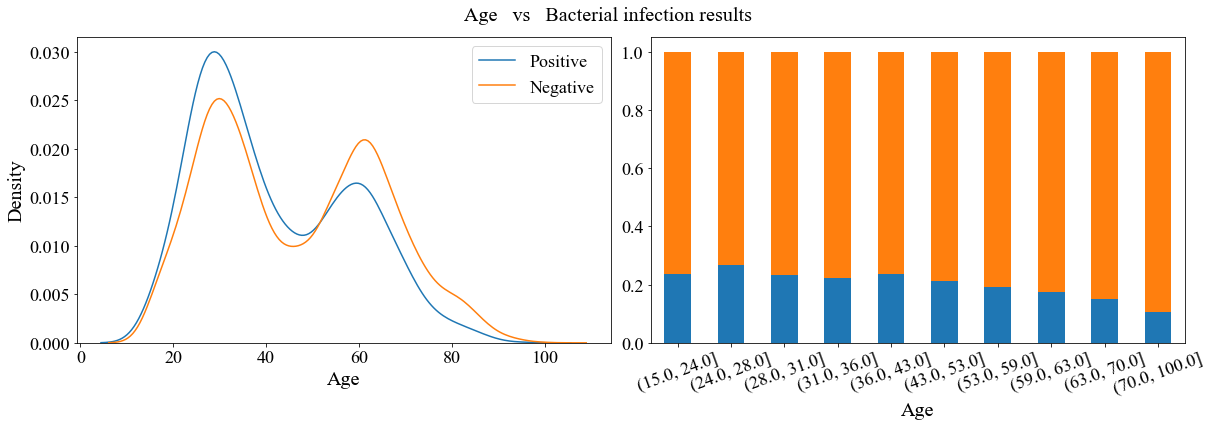

In [50]:
## Distributions visualization of continuous feature
y, x = "细菌结果", "age"
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       sharex=False,
                       sharey=False,
                       figsize=(17, 6))

font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 18,
         }

font2 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,
         }

font3 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 23,
         }

fig.suptitle("Age" + "   vs   " + "Bacterial infection results",
             fontsize=20, fontproperties=font3)

# line
for i in df[y].unique():
    sns.distplot(df[df[y] == i][x], hist=False, label="Negative" if i==0 else "Positive", ax=ax[0])
ax[0].legend(prop=font1,loc='best')
ax[0].set_xlabel('Age',font2)
ax[0].set_ylabel('Density',font2)
ax[0].tick_params(labelsize=18)
labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

# stacked
breaks = np.quantile(df[x], q=np.linspace(0, 1, 11))
tmp = df.groupby([y, pd.cut(df[x], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[y].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar',
                             stacked=True,
                             ax=ax[1],
                             legend=False,)
                             #grid=True)
ax[1].set_xlabel('Age',font2)
plt.xticks(rotation=20);

ax[1].tick_params(labelsize=18)
labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
fig.tight_layout()
plt.show();

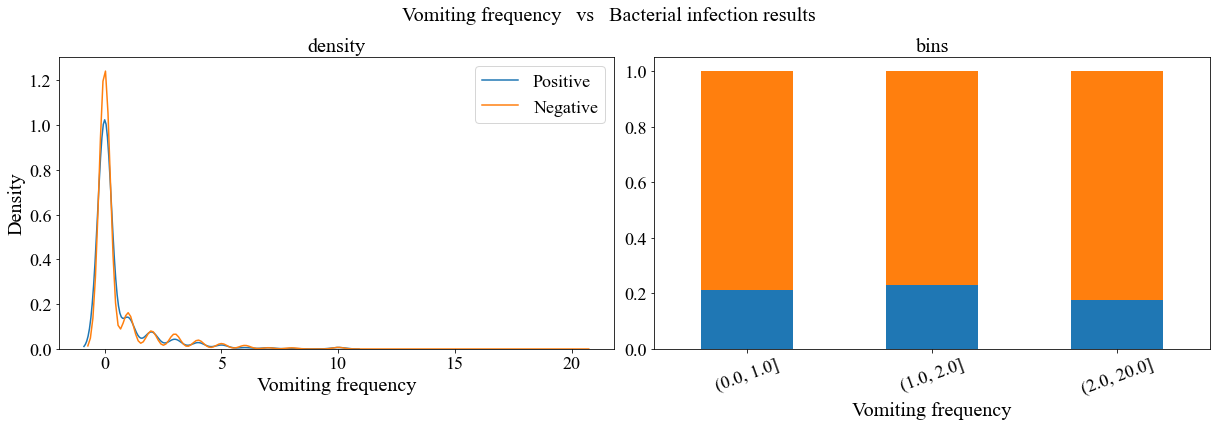

In [51]:
# Distributions visualization of categorical feature
y, x = "细菌结果", "呕吐频次"
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       sharex=False,
                       sharey=False,
                       figsize=(17, 6))

fig.suptitle("Vomiting frequency" + "   vs   " +
             "Bacterial infection results", fontsize=20, fontproperties=font3)

# line
ax[0].set_title('density', fontproperties=font2)
for i in df[y].unique():
    sns.distplot(df[df[y] == i][x], hist=False,
                 label="Negative" if i == 0 else "Positive", ax=ax[0])
# ax[0].grid(True)
ax[0].legend(prop=font1, loc='best')
ax[0].set_xlabel('Vomiting frequency', font2)
ax[0].set_ylabel('Density', font2)
ax[0].tick_params(labelsize=18)
labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

# stacked
ax[1].set_title('bins', fontproperties=font2)
breaks = np.quantile(df[x], q=np.linspace(0, 1, 11))
tmp = df.groupby([y, pd.cut(df[x], breaks, duplicates='drop')]
                 ).size().unstack().T
tmp = tmp[df[y].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar',
                             stacked=True,
                             ax=ax[1],
                             legend=False,)
ax[1].set_xlabel('Vomiting frequency', font2)
plt.xticks(rotation=20)
ax[1].tick_params(labelsize=18)
labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
fig.tight_layout()
plt.show();

In [52]:
## Categorical data: chi-square test
def correlation_chi2(x,y,df):
    """
    Chi-Square test: for two categorical factors
    """
    cont_table = pd.crosstab(index=df[x], columns=df[y])
    chi2_test = scipy.stats.chi2_contingency(cont_table)
    chi2, p = chi2_test[0], chi2_test[1]
    n = cont_table.sum().sum()
    phi2 = chi2/n
    r,k = cont_table.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
    coeff, p = round(coeff, 3), round(p, 3)
    conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
    # conclusion = "Significant" if p < 0.05 else "Non-Significant"
    # print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")
    return coeff, p, conclusion
    
y = "细菌结果"
obj_coeff = []
obj_p = []
obj_conclusion = []
for column in obj_columns:
    coeff, p, conclusion = correlation_chi2(column,y,df)
    obj_coeff.append(coeff)
    obj_p.append(p)
    obj_conclusion.append(conclusion)

list_of_tuple = list(zip(obj_coeff,obj_p,obj_conclusion))
obj_result = pd.DataFrame(data=list_of_tuple,index=obj_columns,columns=["Coeff", "P Value", "Effective"])
obj_result.head(7)

,Coeff,P Value,Effective
区县,0.431,0.000,Correlated
性别,0.035,0.000,Correlated
户籍,0.119,0.000,Correlated
职业,0.144,0.000,Correlated
首发症状,0.062,0.000,Correlated
发热,0.101,0.000,Correlated
脱水,0.013,0.136,Non-Correlated


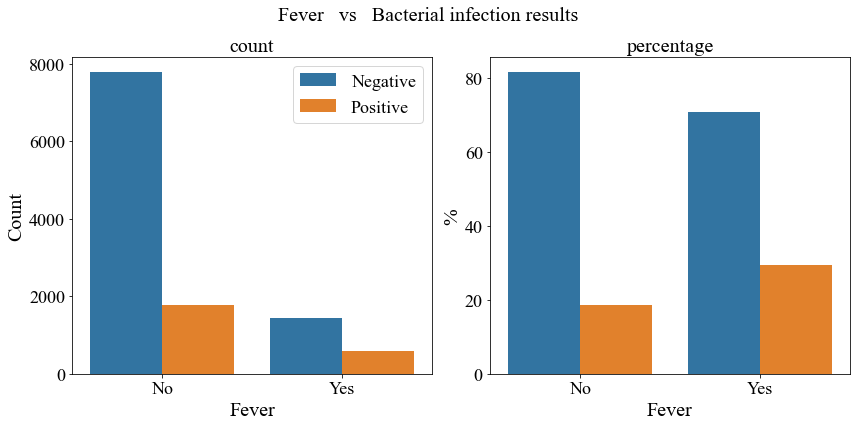

In [53]:
# Visualization
def correlation_plot(x, y, df, feature):
    fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False,
                           sharey=False, figsize=(12, 6))
    fig.suptitle(feature+"   vs   "+"Bacterial infection results",
                 fontsize=20, fontproperties=font3)

    # count
    ax[0].set_title('count', fontproperties=font2)
    order = df.groupby(x)[y].count().index.tolist()
    sns.countplot(x=x, hue=y, data=df, order=order, ax=ax[0])
    # ax[0].grid(True)
    ax[0].legend(prop=font1, loc='best', labels=['Negative', 'Positive'])
    ax[0].set_xlabel(feature, font2)
    ax[0].set_ylabel('Count', font2)
    ax[0].set_xticklabels(['No', 'Yes'])
    ax[0].tick_params(labelsize=18)
    labels = ax[0].get_xticklabels() + ax[0].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    # percentage
    ax[1].set_title('percentage', fontproperties=font2)
    a = df.groupby(x)[y].count().reset_index()
    a = a.rename(columns={y: "tot"})
    b = df.groupby([x, y])[y].count()
    b = b.to_frame()
    b = b.rename(columns={y: 0}).reset_index()
    b = b.merge(a, how="left")
    b["%"] = b[0] / b["tot"] * 100
    sns.barplot(x=x, y="%", hue=y, data=b,
                ax=ax[1]).get_legend().remove()
    # ax[1].grid(True)
    ax[1].set_xticklabels(['No', 'Yes'])
    ax[1].set_xlabel(feature, font2)
    ax[1].set_ylabel('%', font2)
    ax[1].tick_params(labelsize=18)
    labels = ax[1].get_xticklabels() + ax[1].get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    fig.tight_layout()
    plt.show()

## relevant
x, y = "发热", "细菌结果"
correlation_plot(x, y, df, "Fever")

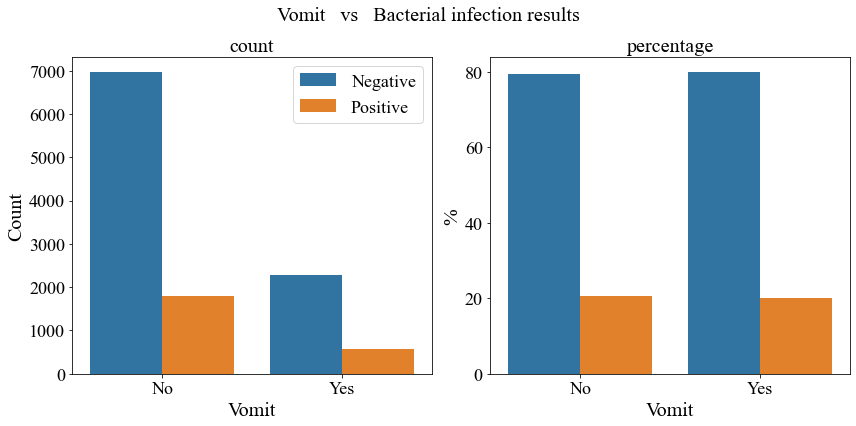

In [54]:
# irrelevant
x, y = "呕吐", "细菌结果"
correlation_plot(x, y, df, 'Vomit')

In [55]:
obj_result = obj_result.drop(columns=['Coeff'], axis=1)

In [56]:
# All features vs selected features

# cont_result + obj_result
cont_obj_result = pd.concat([cont_result, obj_result])
cont_obj_result.head()
final_columns = cont_obj_result[cont_obj_result["Effective"] == "Correlated"].index.to_list()

## Delete irrelevant columns
# if you want to use all features, delete the following code
df = df[final_columns]

,P Value,Effective
age,0.000,Correlated
体温,0.000,Correlated
呕吐频次,0.116,Non-Correlated
持续天数,0.234,Non-Correlated
腹泻量,0.000,Correlated


### Feature representation
#### 1. One-hot encoding

In [59]:
## Statistical-based method + one-hot encoding
df = pd.get_dummies(df, drop_first=True)
df.shape
# 357 features (excluding the label column)

(11600, 358)

In [60]:
y = '细菌结果'
names = df.columns
scaler = preprocessing.MinMaxScaler().fit(df)
df = scaler.transform(df)
df = pd.DataFrame(df, columns=names)

df_normal_file = "data/Diarrhea_statistical_onehot_357.tsv"
df.to_csv(df_normal_file, sep="\t", encoding="utf-8")

features_raw = df.drop(y, axis=1).columns.to_list()

### Stratified sampling

In [61]:
df_train, df_test = train_test_split(df, test_size=0.3,
                                     stratify=df[y], random_state=42)

# print info
print("X_train shape:", df_train.drop(y, axis=1).shape,
      "| X_test shape:", df_test.drop(y, axis=1).shape)
print("y_train mean:", round(
    np.mean(df_train[y]), 2), "| y_test mean:", round(np.mean(df_test[y]), 2))

print('-'*50)

print("Train set：")
print(df_train[y].value_counts() / len(df_train[y]))
print("Test set：")
print(df_test[y].value_counts() / len(df_test[y]))

X_train shape: (8120, 357) | X_test shape: (3480, 357)
y_train mean: 0.2 | y_test mean: 0.2
358 features
--------------------------------------------------
Train set：
0.0    0.795813
1.0    0.204187
Name: 细菌结果, dtype: float64
Test set：
0.0    0.79569
1.0    0.20431
Name: 细菌结果, dtype: float64


In [62]:
X_train = df_train[features_raw]
y_train = df_train[y]

X_test = df_test[features_raw]
y_test = df_test[y]

### Model comparison


In [ ]:
## Logistic Regression
model = LogisticRegression(class_weight='balanced')

# define hyperparameters combinations to try
param_dic = {'penalty': ['l2', 'l1'],
             'C': [0.01, 1, 10],
             'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag'],
             'max_iter': [50, 100]}

# random search
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=1000, cv=10,
                                                   scoring="f1").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean f1:", random_search.best_score_)
model = random_search.best_estimator_

In [65]:
model = LogisticRegression(class_weight='balanced', solver='newton-cg',penalty='l2',max_iter=50, C=1)

In [ ]:
# Naive Bayes
# from sklearn.naive_bayes import BernoulliNB
# model = BernoulliNB()

In [ ]:
# Random Forest
# model = ensemble.RandomForestClassifier(random_state=10)

In [ ]:
## Gradient Boosting Classifier
# model = ensemble.GradientBoostingClassifier(random_state=0)

In [66]:
def train(X, y, model):
    model.fit(X, y)


def eval(X_test, y_test, predicted, predicted_prob, model):

    # Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy, 2))
    print("Auc:", round(auc, 2))

    # Precision e Recall
    recall = metrics.recall_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted)
    print("Recall (all 1s predicted right):", round(recall, 2))
    print("Precision (confidence when predicting a 1):", round(precision, 2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted,
          target_names=[str(i) for i in np.unique(y_test)]))

    # confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(figsize=(7, 5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.tight_layout()
    plt.show()

    return recall, precision, cm

Accuracy (overall correct predictions): 0.71
Auc: 0.75
Recall (all 1s predicted right): 0.6
Precision (confidence when predicting a 1): 0.37
Detail:
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80      2769
         1.0       0.37      0.60      0.45       711

    accuracy                           0.71      3480
   macro avg       0.62      0.67      0.63      3480
weighted avg       0.77      0.71      0.73      3480



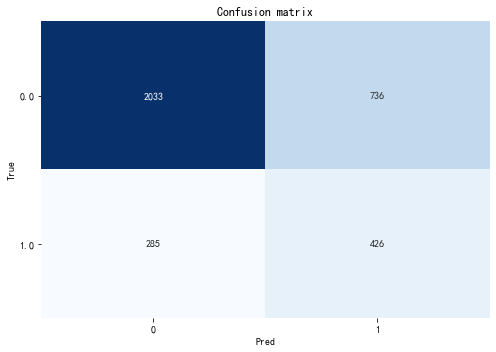

In [68]:
# train
train(X_train, y_train, model)

predicted_prob = model.predict_proba(X_test)[:, 1]
# print(model.predict_proba(X_test))
predicted = model.predict(X_test)
recall, precision, cm = eval(X_test, y_test, predicted, predicted_prob, model)

<AxesSubplot:title={'center':'Threshold Selection'}>

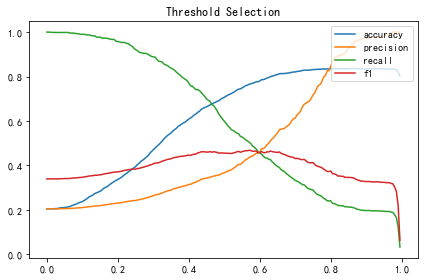

In [69]:
# calculate scores for different thresholds
dic_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
thresholds = []
for threshold in np.arange(0, 1, step=0.005):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(y_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(y_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(y_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(y_test, predicted))

# plot
df_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
df_scores.plot(title="Threshold Selection")
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

Accuracy (overall correct predictions): 0.64
Auc: 0.75
Recall (all 1s predicted right): 0.74
Precision (confidence when predicting a 1): 0.33
Detail:
              precision    recall  f1-score   support

         0.0       0.90      0.62      0.73      2769
         1.0       0.33      0.74      0.46       711

    accuracy                           0.64      3480
   macro avg       0.62      0.68      0.60      3480
weighted avg       0.79      0.64      0.68      3480



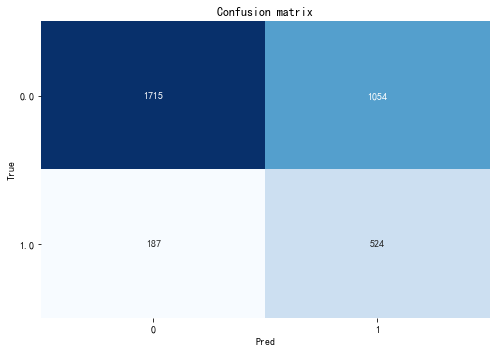

In [74]:
threshold = 0.43
predicted_prob = model.predict_proba(X_test)[:, 1]
predicted = (predicted_prob > threshold)
# predicted = model.predict(X_test)

recall, precision, cm = eval(X_test, y_test, predicted, predicted_prob, model)